In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from shutil import copyfile
import cv2 as cv
from google.colab.patches import cv2_imshow
from cv2 import CascadeClassifier
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from sklearn.neighbors import KDTree
import joblib

## Load dataset 

VIPs dataset

In [128]:
# Link Google Drive account, transfer dataset, and extract files
from google.colab import drive
drive.mount('/content/gdrive')

copyfile('gdrive/My Drive/vip.zip', 'vip.zip')
zip = zipfile.ZipFile('vip.zip')
zip.extractall()
zip.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data loader + face detection

In [2]:
def face_detection(img):
    # funzione che data un'immagine ritorna solamente il crop della faccia che trova al suo interno
    classifier = CascadeClassifier('/haarcascade_frontalface_default.xml')
    box = classifier.detectMultiScale(img, minNeighbors=20)
    #se non trova nessuna faccia non ritorna niente
    (x,y,w,h) = (0,0,0,0)
    if box is ():
        return None
    #altrimenti ritorna solo la prima faccia
    else:
        (x,y,w,h) = box[0]
        return cv.resize(img[y:y+h, x:x+w, :], (224,224))

In [3]:
def load_data():
    # funzione che per con le immagini crea il dataset di train e test applicando prima la funzione di face detection
    root = '/content/thumbnails_features_deduped_publish'

    paths = []
    images = []

    for folder in sorted(os.listdir(root)):
    #dalla cartella principale apro solo le cartelle (no file .txt etc.)
        if not os.path.isfile(root + "/" + folder):
            for file in sorted(os.listdir(root + "/" + folder)):
            # per ogni foto che trovo nelle cartelle vips, opero face detection e salvo il risultato
                if file.endswith('.jpg'):
                    img = cv.imread(root + "/" + folder + "/" + file)
                    img = (face_detection(img))
                    #se il face detector trova un'immagine allora la aggiunge al dataset
                    if img is not None:
                        #preprocessing
                        img = kimage.img_to_array(img)
                        img = keras.applications.mobilenet_v2.preprocess_input(img)
                        img = np.expand_dims(img, axis=0)
                        images.append(img)
                        # lable
                        paths.append(root + "/" + folder + "/" + file)
    return images, paths

In [ ]:
X_train, paths = load_data()

# Feature extraction

In [ ]:
net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

Feature extraction

In [ ]:
X_train = list(map(lambda x: (net.predict(x)).flatten(), X_train))
X_train = np.array(X_train)

# Build KD-Tree

In [ ]:
tree = KDTree(X_train)

Image to query

In [ ]:
query_image = cv.imread("/content/thumbnails_features_deduped_publish/50 cent/0.jpg")
cv2_imshow(query_image)

Preprocessing query

In [ ]:
query_image = face_detection(query_image)
query_features = kimage.img_to_array(query_image)
query_features = keras.applications.mobilenet_v2.preprocess_input(query_features)
query_features = np.expand_dims(query_features, axis=0)
query_features = (net.predict(query_features)).flatten()
query_features = np.expand_dims(query_features, axis=0)

## Ricerca query_image nel KDTree e mostra i num_simil risultati più simili

In [ ]:
dist, ind = tree.query(query_features, k=5)

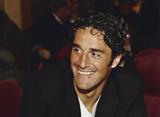

In [125]:
num_simil = 5
for i in range(0,5):
    kimage.load_img(paths[ind[0][i]])

## Salvataggio del KDTree

In [126]:
# Saving the search tree
joblib.dump(tree, 'kdtree.joblib')

['kdtree.joblib']